In [ ]:
import os 
import time
import glob
import pickle
import librosa
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")


In [ ]:
# download all train-val datasets
print('Downloading zip ... started')
!wget https://osf.io/yxwjs/download
print('Downloading zip ... complete')

print('Unzipping ... started')
file_name = '/content/download'
with zipfile.ZipFile(file_name) as file:
    file.extractall()
print('Unzipping ... complete')


--2021-04-03 05:19:05--  https://osf.io/yxwjs/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/q8gzb/providers/osfstorage/6066a35a51f7ae005af515ce?action=download&direct&version=1 [following]
--2021-04-03 05:19:06--  https://files.de-1.osf.io/v1/resources/q8gzb/providers/osfstorage/6066a35a51f7ae005af515ce?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569452523 (543M) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>] 543.07M  25.7MB/s    in 23s     

2021-04-03 05:19:30 (23.9 MB/s) - ‘download’ saved [569452523/569452523]

Unzipping ... started
Unzipping ... complete


In [ ]:
# Download cambridge test set (seprate from above)
print('Downloading zip ... started')
!wget https://osf.io/k8t23/download
print('Downloading zip ... complete')

print('Unzipping ... started')
file_name = '/content/download.1'
with zipfile.ZipFile(file_name) as file:
    file.extractall()
print('Unzipping ... complete')


--2021-04-03 05:21:20--  https://osf.io/k8t23/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/q8gzb/providers/osfstorage/6067093ff2ad330081a78c0d?action=download&direct&version=1 [following]
--2021-04-03 05:21:21--  https://files.de-1.osf.io/v1/resources/q8gzb/providers/osfstorage/6067093ff2ad330081a78c0d?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29505742 (28M) [application/octet-stream]
Saving to: ‘download.1’

download.1          100%[===================>]  28.14M  13.3MB/s    in 2.1s    

2021-04-03 05:21:24 (13.3 MB/s) - ‘download.1’ saved [29505742/29505742]

Unzipping ... started
Unzipping ... complete


In [ ]:
# function defs
def make_train_val_split(dataset_type, file_list):
  train_data = []
  val_data = []

  train_labels = []
  val_labels = []  

  for key in ['_pos', '_neg']:
    temp = file_list[dataset_type+key]
    indx = np.arange(0,len(temp),1)
    np.random.shuffle(indx)
    for i in range(len(indx)):
      if i < int(0.7*len(indx)):
        file_data = open(temp[indx[i]],'rb')
        data = pickle.load(file_data)
        train_data.append(data.values)
        if key == '_pos':
          train_labels.append(1)
        else:
          train_labels.append(0)
      else:
        file_data = open(temp[indx[i]],'rb')
        data = pickle.load(file_data)
        val_data.append(data.values)        
        if key == '_pos':
          val_labels.append(1)
        else:
          val_labels.append(0)        
  return np.stack(train_data), np.stack(val_data), np.stack(train_labels), np.stack(val_labels)


def make_test(file_list):

  test_data = []
  for i in range(len(file_list)):
    file_data = open(file_list[i],'rb')
    data = pickle.load(file_data)
    test_data.append(data.values)
  return np.stack(test_data)

def compute_tp_fp(output, outputRef):
  '''
  computes true positive and false positive
  '''
  tp, fp = [], []
  threshold = np.arange(0,1.0001,.0001)
  for thr in threshold:
    decision = np.zeros((len(outputRef),))
    decision[output>thr] = 1
    # count TP
    temp = sum(decision[outputRef==1]==1)/sum(outputRef==1)
    tp.append(temp)
    temp = sum(decision[outputRef==0]==1)/sum(outputRef==0)
    fp.append(temp)
  return tp, fp


In [ ]:
# read train-val lists
dataset_types = ['cambridge','dicova','epfl']
# make train pos neg list for each type
path_feats = '/content/feats/'
file_list = {}
for key in dataset_types:
  file_list[key+'_pos'] = glob.glob(path_feats + key + '/' + '*_pos.p')
  file_list[key+'_neg'] = glob.glob(path_feats + key + '/' + '*_neg.p')

In [ ]:
# read and make cambridge test
path_feats = '/content/cambridge_test/'
test_list = glob.glob(path_feats + '*.p')
test_X = make_test(test_list)

In [ ]:
test_X.shape

(208, 6373)

In [ ]:
loop_val_auc = []
for iter in range(1):
  loop_val_auc.append([])
  train_X = {}
  train_Y = {}

  val_X = {}
  val_Y = {}

  # load train, val split data for each dataset
  for dataset_type in dataset_types:
    train_X[dataset_type], val_X[dataset_type], train_Y[dataset_type], val_Y[dataset_type] = \
            make_train_val_split(dataset_type, file_list)

  val_auc = {}
  # cross-evaluation
  i = 0
  for dataset_type in dataset_types:
    loop_val_auc[iter].append([])
    scale = StandardScaler().fit(train_X[dataset_type])
    train_X_stand = scale.transform(train_X[dataset_type])
    # clf = RandomForestClassifier(max_depth=6, random_state=0, criterion='gini').fit(train_X_stand, train_Y[dataset_type])
    clf = RandomForestClassifier(max_depth=24, n_estimators=257, criterion='entropy', random_state=0, n_jobs=-1).fit(train_X_stand, train_Y[dataset_type])
    # clf = RandomForestClassifier(max_depth=24, min_samples_leaf=3, n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True, random_state=0).fit(train_X[dataset_type], train_Y[dataset_type])
    for key in dataset_types:
      val_X_stand = scale.transform(val_X[key])
      output_scores = clf.predict_proba(val_X_stand)[:,1]
      tp, fp = compute_tp_fp(output_scores, val_Y[key])
      val_auc[dataset_type+'_'+key] = auc(fp, tp)
      loop_val_auc[iter][i].append(val_auc[dataset_type+'_'+key])
    i = i + 1

  # pooled evaluation
  train_X_all = np.vstack((train_X['cambridge'], train_X['dicova'], train_X['epfl']))
  train_Y_all = np.hstack((train_Y['cambridge'], train_Y['dicova'], train_Y['epfl']))

  loop_val_auc[iter].append([])
  scale = StandardScaler().fit(train_X_all)
  train_X_stand = scale.transform(train_X_all)
  clf = RandomForestClassifier(max_depth=24, n_estimators=257, criterion='entropy', random_state=0, n_jobs=-1).fit(train_X_stand, train_Y_all)
  for key in dataset_types:
    val_X_stand = scale.transform(val_X[key])
    output_scores = clf.predict_proba(val_X_stand)[:,1]
    tp, fp = compute_tp_fp(output_scores, val_Y[key])
    val_auc['pooled'+'_'+key] = auc(fp, tp)
    loop_val_auc[iter][i].append(val_auc['pooled'+'_'+key])


In [ ]:
# to train a system on cambridge and test on the cambridge only
dataset_type = 'cambridge'
train_X = {}
train_Y = {}

val_X = {}
val_Y = {}

train_X[dataset_type], val_X[dataset_type], train_Y[dataset_type], val_Y[dataset_type] = \
            make_train_val_split(dataset_type, file_list)
scale = StandardScaler().fit(train_X[dataset_type])
train_X_stand = scale.transform(train_X[dataset_type])
clf = RandomForestClassifier(max_depth=24, n_estimators=257, criterion='entropy', random_state=0, n_jobs=-1).fit(train_X_stand, train_Y[dataset_type])

test_X_stand = scale.transform(test_X)
output_scores = clf.predict_proba(test_X_stand)[:,1]


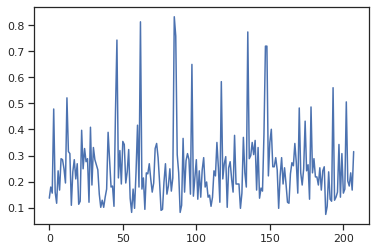

In [ ]:
plt.plot(output_scores)

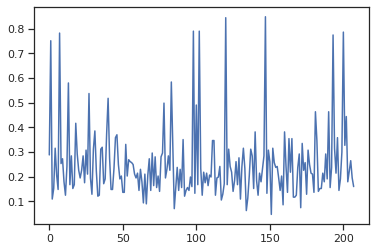

In [ ]:
plt.plot(output_scores)

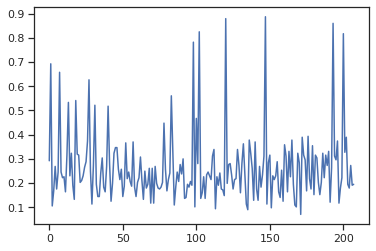

In [ ]:
plt.plot(output_scores)

In [ ]:
df = {}
df['filename'] = []
df['prediction'] = []
thres = 0.3
for i in range(len(output_scores)):
  df['filename'].append(test_list[i].split('/')[-1].split('.p')[0])
  if output_scores[i] >thres:
    df['prediction'].append('positive')
  else:
    df['prediction'].append('negative')


In [ ]:
new = pd.DataFrame.from_dict(df)
new_1 = new.sort_values(by = 'filename')
new_1.to_csv("cambridge_test_scores.csv", index=False)

In [ ]:
new_1

,filename,prediction
31,test_001.wav,positive
83,test_002.wav,negative
122,test_003.wav,positive
89,test_004.wav,negative
105,test_005.wav,positive
...,...,...
156,test_204.wav,negative
10,test_205.wav,negative
107,test_206.wav,negative
163,test_207.wav,negative


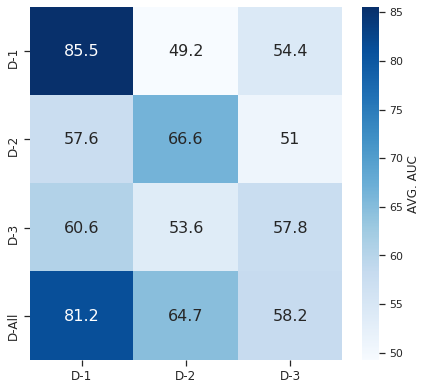

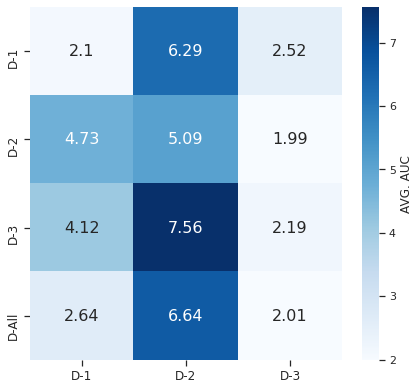

In [ ]:
# plot decisions at 80% sensitivity
temp = np.array(loop_val_auc)
fig = plt.subplots(figsize=(7,6.5))
ax = plt.subplot(1,1,1)
sns.set(font_scale=1.0)#for label size
FS = 12
x_label = ['D-1', 'D-2','D-3']
y_label = ['D-1', 'D-2', 'D-3', 'D-All']

sns.heatmap(np.mean(temp,axis=0)*100, annot=True, fmt='.3g', cmap='Blues', annot_kws={"size": 16},\
            cbar_kws={'label': 'AVG. AUC'})# font size
ax.set_xticks(np.arange(len(x_label))+.5)
ax.set_yticks(np.arange(len(y_label))+.5)
ax.set_xticklabels(x_label,rotation=0,fontsize=FS)
ax.set_yticklabels(y_label,rotation=90,fontsize=FS)
ax.figure.savefig("avg_auc.pdf", bbox_inches='tight')
plt.show()
sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")

# plot decisions at 80% sensitivity
temp = np.array(loop_val_auc)
fig = plt.subplots(figsize=(7,6.5))
ax = plt.subplot(1,1,1)
sns.set(font_scale=1.0)#for label size
FS = 12
x_label = ['D-1', 'D-2','D-3']
y_label = ['D-1', 'D-2', 'D-3', 'D-All']

sns.heatmap(np.std(temp,axis=0)*100, annot=True, fmt='.3g', cmap='Blues', annot_kws={"size": 16},\
            cbar_kws={'label': 'AVG. AUC'})# font size
ax.set_xticks(np.arange(len(x_label))+.5)
ax.set_yticks(np.arange(len(y_label))+.5)
ax.set_xticklabels(x_label,rotation=0,fontsize=FS)
ax.set_yticklabels(y_label,rotation=90,fontsize=FS)
ax.figure.savefig("avg_auc.pdf", bbox_inches='tight')
plt.show()
sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")

In [ ]:
# train and cross-evaluate across datasets
val_auc = {}
for dataset_type in dataset_types:
  scale = StandardScaler().fit(train_X[dataset_type])
  train_X_stand = scale.transform(train_X[dataset_type])
  # clf = RandomForestClassifier(max_depth=6, random_state=0, criterion='gini').fit(train_X_stand, train_Y[dataset_type])
  clf = RandomForestClassifier(max_depth=24, n_estimators=257, criterion='entropy', random_state=0).fit(train_X_stand, train_Y[dataset_type])
  # clf = RandomForestClassifier(max_depth=24, min_samples_leaf=3, n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True, random_state=0).fit(train_X[dataset_type], train_Y[dataset_type])
  for key in dataset_types:
    val_X_stand = scale.transform(val_X[key])
    output_scores = clf.predict_proba(val_X_stand)[:,1]
    tp, fp = compute_tp_fp(output_scores, val_Y[key])
    val_auc[dataset_type+'_'+key] = auc(fp, tp)

# pooled evaluation
train_X_all = np.vstack((train_X['cambridge'], train_X['dicova'], train_X['epfl']))
train_Y_all = np.hstack((train_Y['cambridge'], train_Y['dicova'], train_Y['epfl']))

train_X_stand = scale.transform(train_X_all)
clf = RandomForestClassifier(max_depth=24, n_estimators=257, criterion='entropy', random_state=0).fit(train_X_stand, train_Y_all)
for key in dataset_types:
  val_X_stand = scale.transform(val_X[key])
  output_scores = clf.predict_proba(val_X_stand)[:,1]
  tp, fp = compute_tp_fp(output_scores, val_Y[key])
  val_auc['pooled'+'_'+key] = auc(fp, tp)



In [ ]:
for i in range(4):
  for j in range(3):
    

{'cambridge_cambridge': 0.8284722222222222,
 'cambridge_dicova': 0.41986506746626684,
 'cambridge_epfl': 0.5446764752412594,
 'dicova_cambridge': 0.5859953703703704,
 'dicova_dicova': 0.5869565217391304,
 'dicova_epfl': 0.4640246796392976,
 'epfl_cambridge': 0.6812500000000001,
 'epfl_dicova': 0.5485007496251874,
 'epfl_epfl': 0.6114064230343299,
 'pooled_cambridge': 0.7378472222222223,
 'pooled_dicova': 0.6432533733133434,
 'pooled_epfl': 0.5789273849074514}

In [ ]:
val_auc

{'cambridge_cambridge': 0.8520833333333334,
 'cambridge_dicova': 0.42743628185907045,
 'cambridge_epfl': 0.5390128144280968,
 'dicova_cambridge': 0.5509259259259259,
 'dicova_dicova': 0.6413043478260869,
 'dicova_epfl': 0.47775668406897637,
 'epfl_cambridge': 0.6275462962962963,
 'epfl_dicova': 0.5501499250374813,
 'epfl_epfl': 0.6241101091599431,
 'pooled_cambridge': 0.8012731481481482,
 'pooled_dicova': 0.6634932533733134,
 'pooled_epfl': 0.5975794969150452}

In [ ]:
val_auc

{'cambridge_cambridge': 0.8440972222222222,
 'cambridge_dicova': 0.42631184407796097,
 'cambridge_epfl': 0.5482993197278913,
 'dicova_cambridge': 0.5487268518518518,
 'dicova_dicova': 0.5962518740629683,
 'dicova_epfl': 0.47256763170384436,
 'epfl_cambridge': 0.597337962962963,
 'epfl_dicova': 0.5866566716641679,
 'epfl_epfl': 0.615092548647366,
 'pool_cambridge': 0.7378472222222223,
 'pool_dicova': 0.6432533733133434,
 'pool_epfl': 0.5789273849074514}

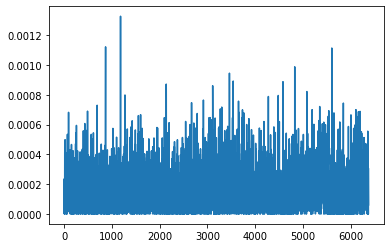

In [ ]:
plt.plot(clf.feature_importances_)

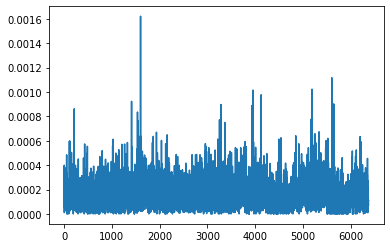

In [ ]:
plt.plot(clf.feature_importances_)

In [ ]:
https://osf.io/k8t23/download